In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Fitpluse_Helath_Anomaly_Detection/clean_fitness_data_minute.csv')

In [ ]:
df.head()

,timestamp,heart_rate,steps,sleep
0,2025-04-10 09:00:00+00:00,63.0,528.0,0.0
1,2025-04-10 09:01:00+00:00,NaN,NaN,NaN
2,2025-04-10 09:02:00+00:00,NaN,NaN,NaN
3,2025-04-10 09:03:00+00:00,NaN,NaN,NaN
4,2025-04-10 09:04:00+00:00,NaN,NaN,NaN


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [ ]:
WINDOW_SIZE = 10    # number of rows per window
STEP_SIZE = 10      # overlap

rows = []
window_id = 0

for start in range(0, len(df) - WINDOW_SIZE, STEP_SIZE):
    window = df.iloc[start:start + WINDOW_SIZE].copy()
    window["id"] = window_id
    rows.append(window)
    window_id += 1

df_windowed = pd.concat(rows)


In [ ]:
ts_df = df_windowed[['id', 'timestamp', 'heart_rate']].copy()
ts_df.columns = ['id', 'time', 'value']

In [ ]:
# Safety cleaning
ts_df.replace([np.inf, -np.inf], np.nan, inplace=True)
ts_df.dropna(inplace=True)

#If infinity / NaN exists → TSFresh WILL FAIL.

In [ ]:
print(df.columns)

Index(['timestamp', 'heart_rate', 'steps', 'sleep'], dtype='object')


In [ ]:
from tsfresh import extract_features

features = extract_features(
    ts_df,
    column_id='id',
    column_sort='time'
)

features = features.fillna(0)

Feature Extraction: 100%|██████████| 249/249 [00:20<00:00, 12.03it/s]


In [ ]:
features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,134.0,9010.0,8.0,8.0,0.0,67.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,288.0,41810.0,26.0,26.0,0.0,144.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,201.0,21713.0,55.0,55.0,0.0,100.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,303.0,46589.0,37.0,37.0,0.0,151.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,257.0,33865.0,41.0,-41.0,0.0,128.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1.0,0.0,0.0,0.0,285.0,42597.0,63.0,-63.0,0.0,142.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,1.0,0.0,0.0,0.0,220.0,26792.0,72.0,72.0,0.0,110.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246,1.0,0.0,0.0,0.0,182.0,18362.0,60.0,-60.0,0.0,91.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247,1.0,0.0,0.0,0.0,205.0,22117.0,47.0,-47.0,0.0,102.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=100,
    contamination=0.05, #5%
    random_state=42
)

features_filled = features.fillna(0)

anomaly_labels = model.fit_predict(features_filled)

features['anomaly'] = anomaly_labels


In [ ]:
features['anomaly'].value_counts()

,count
anomaly,
1,236
-1,13


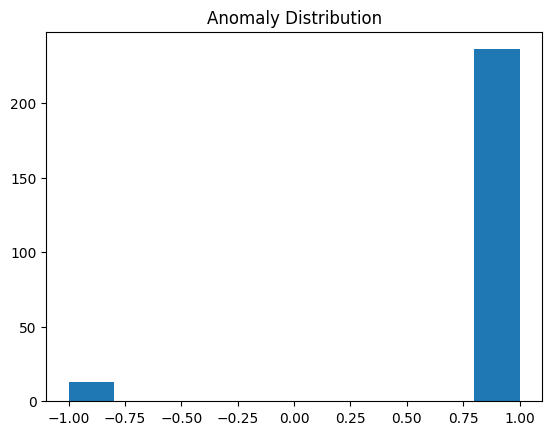

In [ ]:
import matplotlib.pyplot as plt

plt.hist(anomaly_labels)
plt.title("Anomaly Distribution")
plt.show()


In [ ]:
df.columns

Index(['timestamp', 'heart_rate', 'steps', 'sleep'], dtype='object')

In [ ]:
sensor_columns = ['heart_rate', 'steps', 'sleep']

long_df = df_windowed.melt(
    id_vars=['id', 'timestamp'],
    value_vars=sensor_columns,
    var_name='kind',
    value_name='value'
)

long_df.rename(columns={
    'timestamp': 'time'
}, inplace=True)

long_df.replace([np.inf, -np.inf], np.nan, inplace=True)
long_df.dropna(inplace=True)

In [ ]:
from tsfresh import extract_features

features = extract_features(
    long_df,
    column_id='id',
    column_sort='time',
    column_kind='kind',
    column_value='value'
)

features = features.fillna(0)
features.head()

Feature Extraction: 100%|██████████| 747/747 [01:07<00:00, 11.07it/s]


,heart_rate__variance_larger_than_standard_deviation,heart_rate__has_duplicate_max,heart_rate__has_duplicate_min,heart_rate__has_duplicate,heart_rate__sum_values,heart_rate__abs_energy,heart_rate__mean_abs_change,heart_rate__mean_change,heart_rate__mean_second_derivative_central,heart_rate__median,...,steps__fourier_entropy__bins_5,steps__fourier_entropy__bins_10,steps__fourier_entropy__bins_100,steps__permutation_entropy__dimension_3__tau_1,steps__permutation_entropy__dimension_4__tau_1,steps__permutation_entropy__dimension_5__tau_1,steps__permutation_entropy__dimension_6__tau_1,steps__permutation_entropy__dimension_7__tau_1,steps__query_similarity_count__query_None__threshold_0.0,steps__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,0.0,134.0,9010.0,8.0,8.0,0.0,67.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,288.0,41810.0,26.0,26.0,0.0,144.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,201.0,21713.0,55.0,55.0,0.0,100.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,303.0,46589.0,37.0,37.0,0.0,151.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,257.0,33865.0,41.0,-41.0,0.0,128.5,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05, random_state=42)
labels = model.fit_predict(features)

features['anomaly'] = labels


In [ ]:
df['anomaly'] = 1

for wid in features.query("anomaly == -1").index:
    df.loc[wid:wid+WINDOW_SIZE-1, 'anomaly'] = -1

In [ ]:
df['anomaly'].value_counts()

,count
anomaly,
1,2389
-1,107


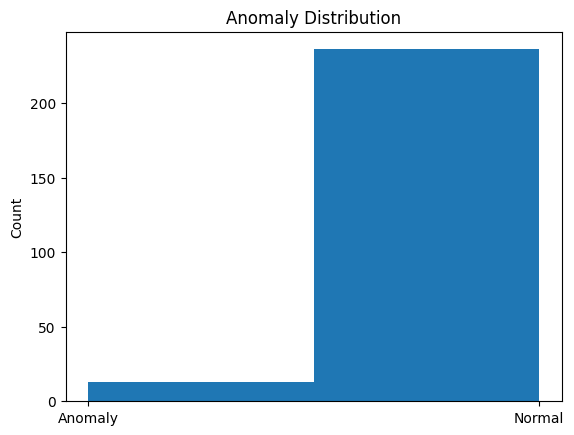

In [ ]:
import matplotlib.pyplot as plt

plt.hist(anomaly_labels, bins=2)
plt.xticks([-1, 1], ['Anomaly', 'Normal'])
plt.title("Anomaly Distribution")
plt.ylabel("Count")
plt.show()

In [ ]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame({ "Anomaly Label": anomaly_labels })

fig = px.histogram(
    df_plot,
    x="Anomaly Label",
    nbins=2,
    title="Anomaly Distribution"
)

# Replace -1 / 1 with readable labels
fig.update_xaxes(
    tickvals=[-1, 1],
    ticktext=["Anomaly", "Normal"]
)

fig.update_yaxes(title="Count")

fig.show()


Clean data with _clean_for_tsfresh

Extract TSFresh features with extract_tsfresh_features

Auto-select top features with auto_select_features

In [ ]:
df_clean = clean_for_tsfresh(df)
print("\nCleaned DataFrame:")
print(df_clean)


Cleaned DataFrame:
                     timestamp  heart_rate  steps  sleep  anomaly
0    2025-04-10 09:00:00+00:00        63.0  528.0    0.0       -1
5    2025-04-10 09:05:00+00:00        71.0  330.0    0.0       -1
10   2025-04-10 09:10:00+00:00       131.0  858.0    0.0        1
15   2025-04-10 09:15:00+00:00       157.0  732.0    0.0        1
20   2025-04-10 09:20:00+00:00        73.0  667.0    0.0        1
...                        ...         ...    ...    ...      ...
2475 2025-04-12 02:15:00+00:00        79.0  355.0    0.0        1
2480 2025-04-12 02:20:00+00:00       169.0  803.0    0.0        1
2485 2025-04-12 02:25:00+00:00       124.0  687.0    0.0        1
2490 2025-04-12 02:30:00+00:00       162.0  810.0    0.0        1
2495 2025-04-12 02:35:00+00:00        73.0  870.0    0.0        1

[500 rows x 5 columns]


In [ ]:
import numpy as np

def clean_for_tsfresh(df_input):
    df_cleaned = df_input.copy()
    df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_cleaned.dropna(inplace=True)
    return df_cleaned


In [ ]:
features

,heart_rate__variance_larger_than_standard_deviation,heart_rate__has_duplicate_max,heart_rate__has_duplicate_min,heart_rate__has_duplicate,heart_rate__sum_values,heart_rate__abs_energy,heart_rate__mean_abs_change,heart_rate__mean_change,heart_rate__mean_second_derivative_central,heart_rate__median,...,steps__fourier_entropy__bins_10,steps__fourier_entropy__bins_100,steps__permutation_entropy__dimension_3__tau_1,steps__permutation_entropy__dimension_4__tau_1,steps__permutation_entropy__dimension_5__tau_1,steps__permutation_entropy__dimension_6__tau_1,steps__permutation_entropy__dimension_7__tau_1,steps__query_similarity_count__query_None__threshold_0.0,steps__mean_n_absolute_max__number_of_maxima_7,anomaly
0,1.0,0.0,0.0,0.0,134.0,9010.0,8.0,8.0,0.0,67.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,1.0,0.0,0.0,0.0,288.0,41810.0,26.0,26.0,0.0,144.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,0.0,0.0,0.0,201.0,21713.0,55.0,55.0,0.0,100.5,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,303.0,46589.0,37.0,37.0,0.0,151.5,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1.0,0.0,0.0,0.0,257.0,33865.0,41.0,-41.0,0.0,128.5,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,1.0,0.0,0.0,0.0,285.0,42597.0,63.0,-63.0,0.0,142.5,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
245,1.0,0.0,0.0,0.0,220.0,26792.0,72.0,72.0,0.0,110.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
246,1.0,0.0,0.0,0.0,182.0,18362.0,60.0,-60.0,0.0,91.0,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
247,1.0,0.0,0.0,0.0,205.0,22117.0,47.0,-47.0,0.0,102.5,...,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
features.to_csv("tsfresh_features.csv")
files.download("tsfresh_features.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>